In [1]:
import openpiv.tools
import openpiv.process
import openpiv.scaling
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline

In [2]:
fname = 'test_images/Frame0000Step%04d.tif'
frame_a  = openpiv.tools.imread( fname%163 )
frame_b  = openpiv.tools.imread( fname%173 )

/Users/timrudge/miniconda/envs/piv/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


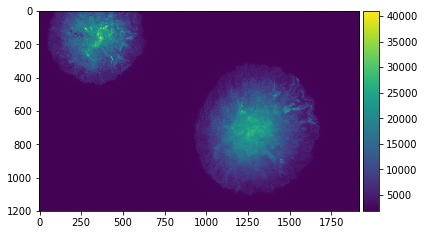

In [3]:
io.imshow(frame_a)

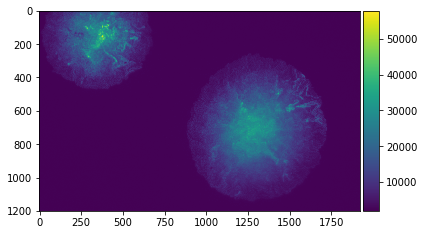

In [4]:
io.imshow(frame_b)

In [5]:
cv_frame_a = frame_a.astype(np.float32)
cv_frame_a = 255.0*cv_frame_a/cv_frame_a.max()
cv_frame_b = frame_b.astype(np.float32)
cv_frame_b = 255.0*cv_frame_b/cv_frame_b.max()

'''
# Translated by 20 pixels
cv_frame = cv_frame_a
cv_frame_a = cv_frame[20:,:]
cv_frame_b = cv_frame[:-20,:]

# Scale by 1.05
w,h = cv_frame_a.shape
sw,sh = w-118,h-192
scx,scy = w/sw,h/sh
cv_frame_b = cv2.resize(cv_frame_a[0:-118,0:-192], (h,w))
'''

# Crop images
cv_frame_a = cv_frame_a[0:256,250:506]
cv_frame_b = cv_frame_b[0:256,250:506]

w,h = cv_frame_a.shape

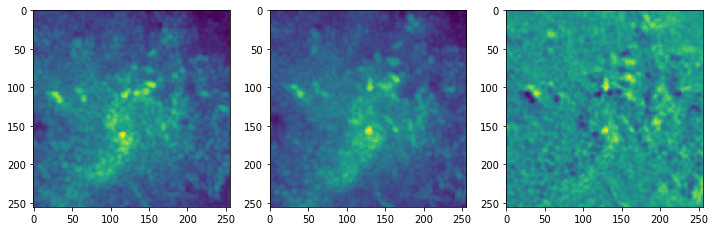

In [7]:
th_frame_a = cv2.adaptiveThreshold(cv_frame_a.astype(np.uint8),255,cv2.ADAPTIVE_THRESH_MEAN_C,\
                cv2.THRESH_BINARY,11,0)
plt.figure(figsize=(12,6))
plt.subplot(131)
plt.imshow(cv_frame_a)
th_frame_b = cv2.adaptiveThreshold(cv_frame_b.astype(np.uint8),255,cv2.ADAPTIVE_THRESH_MEAN_C,\
                cv2.THRESH_BINARY,11,0)
plt.subplot(132)
plt.imshow(cv_frame_b)
plt.subplot(133)
plt.imshow(cv_frame_b-cv_frame_a)

In [204]:
u, v, sig2noise = openpiv.process.extended_search_area_piv( th_frame_a.astype(np.int32), \
                                                           th_frame_b.astype(np.int32), \
                                                           window_size=64, \
                                                           overlap=48, \
                                                           dt=1, \
                                                           search_area_size=128, \
                                                           sig2noise_method='peak2peak' )

In [205]:
x, y = openpiv.process.get_coordinates( image_size=cv_frame_a.shape, window_size=64, overlap=48 )
#x, y = openpiv.process.get_coordinates( image_size=(500,500), window_size=50, overlap=40 )

In [206]:
u, v, mask = openpiv.validation.sig2noise_val( u, v, sig2noise, threshold = 1.0 )

In [207]:
u, v = openpiv.filters.replace_outliers( u, v, method='localmean', max_iter=10, kernel_size=2)

In [208]:
x, y, u, v = openpiv.scaling.uniform(x, y, u, v, scaling_factor = 1 )

In [209]:
openpiv.tools.save(x, y, u, v, mask, 'exp1_001.txt' )

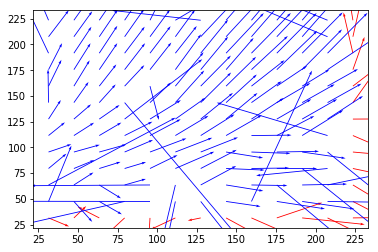

In [210]:
openpiv.tools.display_vector_field('exp1_001.txt', scale=100, width=0.0025)

/Users/timrudge/miniconda/envs/piv/lib/python2.7/site-packages/ipykernel/__main__.py:3: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  app.launch_new_instance()
/Users/timrudge/miniconda/envs/piv/lib/python2.7/site-packages/ipykernel/__main__.py:8: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


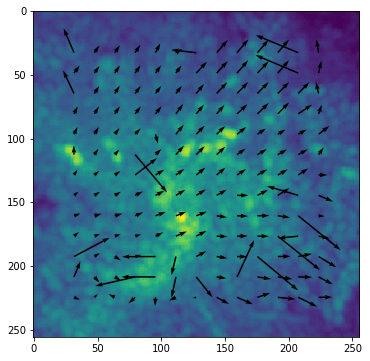

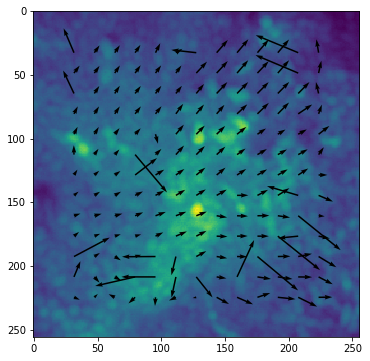

In [211]:
plt.figure(figsize=(6,6))
plt.imshow(cv_frame_a)
plt.hold(True)
plt.quiver( x, cv_frame_a.shape[1]-y, u, v )

plt.figure(figsize=(6,6))
plt.imshow(cv_frame_b)
plt.hold(True)
plt.quiver( x, cv_frame_b.shape[1]-y, u, v )

(256, 256)

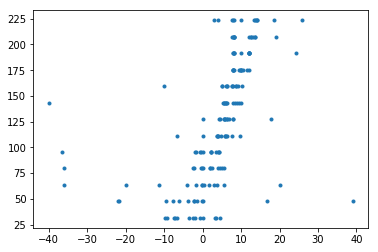

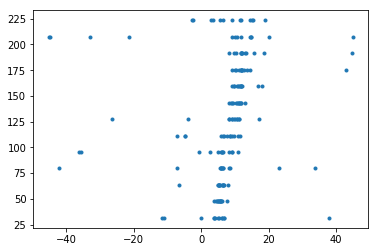

In [212]:
#plt.hist(v.ravel())
plt.figure()
plt.plot(v.ravel(), y.ravel(), '.')
#plt.plot((1.0/0.9-1)*(y.ravel()-200), y.ravel(), '.')

plt.figure()
plt.plot(u.ravel(), x.ravel(), '.')
#plt.plot((1.0/0.9-1)*(x.ravel()+249), x.ravel(), '.')
#plt.xlim((30,50))
cv_frame_b.shape

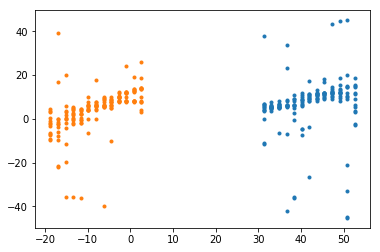

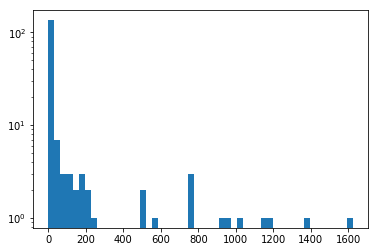

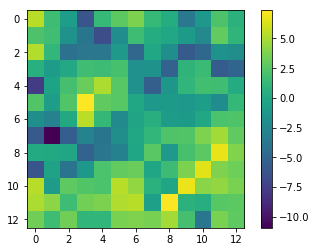

In [213]:
su = cv2.GaussianBlur(u,(5,5),0)
sv = cv2.GaussianBlur(v,(5,5),0)

#plt.plot(su.ravel(), x.ravel(), '.')
#plt.plot(x.ravel()*0.05, u.ravel(),'.')
xtrue = (1.0/0.9-1)*(x.ravel()+250)
xerr = (su.ravel()-u.ravel())

ytrue = (1.0/0.9-1)*(y.ravel()-200)
yerr = (sv.ravel()-v.ravel())

plt.plot(xtrue, u.ravel(), '.')
plt.plot(ytrue, v.ravel(), '.')
plt.figure()
#plt.hist(xerr, 20)
plt.hist((xerr*xerr), 50)
plt.yscale('log', nonposy='clip')
xerr.mean()

plt.figure()
xerr.shape=x.shape
yerr.shape=y.shape
plt.imshow(np.log(yerr*yerr))
plt.colorbar()

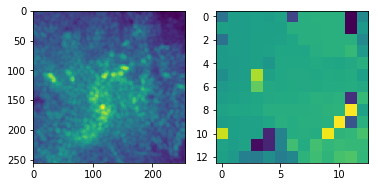

In [214]:
plt.subplot(121)
plt.imshow(cv_frame_a)
plt.subplot(122)
plt.imshow(u)

-0.1827419516260195

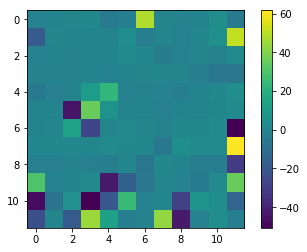

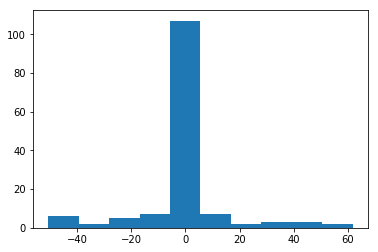

In [215]:
du = np.diff(u, axis=0)
dv = np.diff(v, axis=1)
div = du[:,:-1] + dv[:-1,:]
plt.imshow(div)
plt.colorbar()
plt.figure()
plt.hist(div.ravel())
np.mean(div.ravel())

(13, 13)

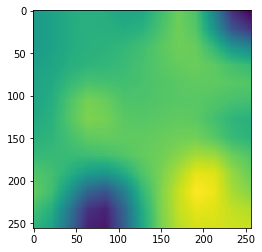

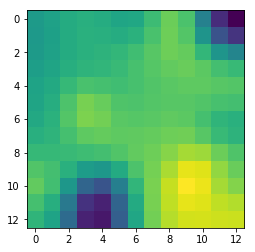

In [219]:
(cx,cy) = cv2.convertMaps(x.astype(np.float32), y.astype(np.float32), cv2.CV_32FC1)
hhx = (x-u).astype(np.float32)
hhy = (y-v).astype(np.float32)
xx = np.linspace(0,12,w).astype(np.float32)
yy = np.linspace(0,12,h).astype(np.float32)
xv,yv = np.meshgrid(xx,yy)
ufull = cv2.remap(su, xv.astype(np.float32), yv.astype(np.float32), cv2.INTER_LINEAR).astype(np.float32)
vfull = cv2.remap(sv, xv.astype(np.float32), yv.astype(np.float32), cv2.INTER_LINEAR).astype(np.float32)
plt.imshow(ufull)
plt.figure()
plt.imshow(su)
u.shape

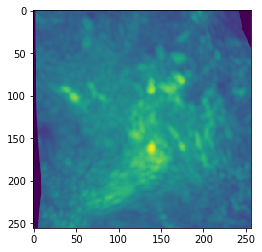

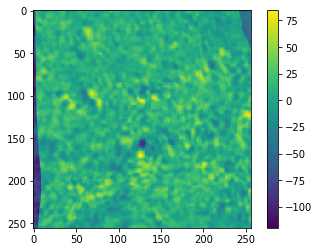

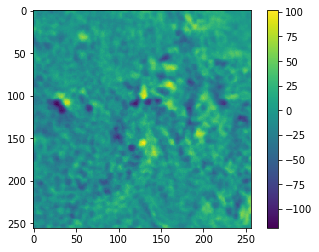

In [220]:

xv,yv = np.meshgrid(np.arange(0,w),np.arange(0,h))
w_frame_a = cv2.remap(cv_frame_a, xv.astype(np.float32)-ufull, yv.astype(np.float32)+vfull[:,-1:], cv2.INTER_LINEAR)
w_frame_b = cv2.remap(cv_frame_b, xv.astype(np.float32)-ufull, yv.astype(np.float32)+vfull[:,-1:], cv2.INTER_LINEAR)
plt.figure()
plt.imshow(w_frame_b)
plt.figure()
plt.imshow((w_frame_a-cv_frame_b))
plt.colorbar()
plt.figure()
plt.imshow((cv_frame_b-cv_frame_a))
plt.colorbar()


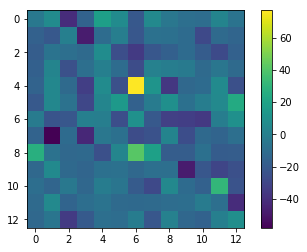

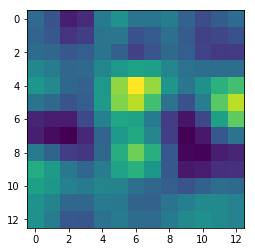

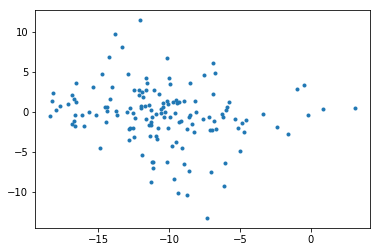

In [222]:
df_full = cv_frame_b - w_frame_a
df = cv2.remap(df_full, x.astype(np.float32),  y.astype(np.float32), cv2.INTER_LINEAR)
plt.figure()
plt.imshow(df)
plt.colorbar()
df.shape

sdf = cv2.GaussianBlur(df, (5,5), 0)
plt.figure()
plt.imshow(sdf)
sdiv = cv2.GaussianBlur(div, (5,5), 0)
plt.figure()
plt.plot(sdf[0:-1,0:-1].ravel(), sdiv.ravel(), '.')
#plt.ylim(0,0.5)